In [1]:

import gzip
import os
import pickle
from urllib.request import urlretrieve

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
try:
    import requests
    has_requests = True
except ImportError:
    has_requests = False

import nengo_loihi
import keras

W1204 12:01:04.759284  4056 module_wrapper.py:139] From c:\python36\lib\site-packages\nengo_dl\compat.py:26: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1204 12:01:04.763277  4056 module_wrapper.py:139] From c:\python36\lib\site-packages\nengo_dl\__init__.py:38: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W1204 12:01:04.764275  4056 module_wrapper.py:139] From c:\python36\lib\site-packages\nengo_dl\__init__.py:38: The name tf.logging.WARN is deprecated. Please use tf.compat.v1.logging.WARN instead.

W1204 12:01:04.765270  4056 module_wrapper.py:139] From c:\python36\lib\site-packages\nengo_dl\__init__.py:43: The name tf.disable_v2_behavior is deprecated. Please use tf.compat.v1.disable_v2_behavior instead.

W1204 12:01:04.767264  4056 deprecation.py:323] From c:\python36\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops

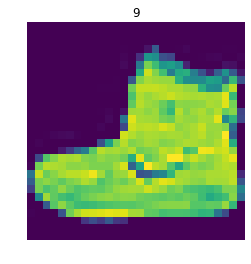

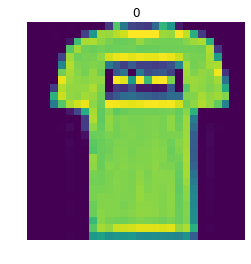

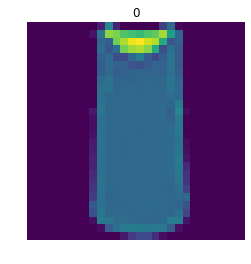

In [11]:
(train_images, train_labels), (test_images, test_labels) = (
    keras.datasets.fashion_mnist.load_data())

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

train_data = [train_images/254, train_labels]
test_data = [test_images/254, test_labels]
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

# plot some examples
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)))
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

In [3]:
def conv_layer(x, *args, activation=True, **kwargs):
    # create a Conv2D transform with the given arguments
    conv = nengo.Convolution(*args, channels_last=False, **kwargs)

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(conv.output_shape.size, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=conv.output_shape.size)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=conv)

    # print out the shape information for our new layer
    print("LAYER")
    print(conv.input_shape.shape, "->", conv.output_shape.shape)

    return layer, conv

In [12]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28, 28)

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = (
        nengo.SpikingRectifiedLinear(amplitude=amp))
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28)

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=10)

    # build parallel copies of the network
    layer, conv = conv_layer(
        inp, 1, input_shape, kernel_size=(1, 1),
        init=np.ones((1, 1, 1, 1)))
    # first layer is off-chip to translate the images into spikes
    net.config[layer.ensemble].on_chip = False
    layer, conv = conv_layer(layer, 16, conv.output_shape,
                             strides=(1, 1), kernel_size=(5, 5))
    layer, conv = conv_layer(layer, 24, conv.output_shape,
                             strides=(2, 2), kernel_size=(5, 5))
    #layer, conv = conv_layer(layer, 32, conv.output_shape,
    #                         strides=(1, 1), kernel_size=(3, 3))
    nengo.Connection(layer, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (16, 24, 24)
LAYER
(16, 24, 24) -> (24, 10, 10)


In [13]:
# set up training data
minibatch_size = 200
train_data = {inp: train_data[0][:, None, :],
              out_p: train_data[1][:, None, :]}

# for the test data evaluation we'll be running the network over time
# using spiking neurons, so we need to repeat the input/target data
# for a number of timesteps (based on the presentation_time)
test_data = {
    inp: np.tile(test_data[0][:, None, :],
                 (1, int(presentation_time / dt), 1)),
    out_p_filt: np.tile(test_data[1][:, None, :],
                        (1, int(presentation_time / dt), 1))
}

In [6]:
def crossentropy(outputs, targets):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=outputs, labels=targets))


def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1),
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))

In [15]:
do_training = True

with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0) as sim:
    if do_training:
        #print("error before training: %.2f%%" %
        #      sim.loss(test_data, {out_p_filt: classification_error}))

        # run training
        sim.train(train_data, tf.train.RMSPropOptimizer(learning_rate=0.001),
                  objective={out_p: crossentropy}, n_epochs=5)

        print("error after training: %.2f%%" %
              sim.loss(test_data, {out_p_filt: classification_error}))

        sim.save_params("./mnist_params4")
    else:
        #download("mnist_params.data-00000-of-00001",
        #         "1BaNU7Er_Q3SJt4i4Eqbv1Ln_TkmmCXvy")
        #download("mnist_params.index", "1w8GNylkamI-3yHfSe_L1-dBtvaQYjNlC")
        #download("mnist_params.meta", "1JiaoxIqmRupT4reQ5BrstuILQeHNffrX")
        sim.load_params("./mnist_params4")

    # store trained parameters back into the network
    sim.freeze_params(net)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               ##################################################################################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00
Training finished in 0:02:12 (loss: 0.2528)                                    
Calculation finished in 0:02:06                                                
error after training: 88.47%


In [9]:
for conn in net.all_connections:
    conn.synapse = 0.005


with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    print("error w/ synapse: %.2f%%" %
          sim.loss(test_data, {out_p_filt: classification_error}))

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               #########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [ ]:
n_presentations = 50
with nengo_loihi.Simulator(net, dt=dt, precompute=False) as sim:
    # if running on Loihi, increase the max input spikes per step
    if 'loihi' in sim.sims:
        sim.sims['loihi'].snip_max_spikes_per_step = 120

    # run the simulation on Loihi
    sim.run(n_presentations * presentation_time)

    # check classification error
    step = int(presentation_time / dt)
    output = sim.data[out_p_filt][step - 1::step]
    correct = 100 * (np.mean(
        np.argmax(output, axis=-1)
        != np.argmax(test_data[out_p_filt][:n_presentations, -1],
                     axis=-1)
    ))
    print("loihi error: %.2f%%" % correct)

In [ ]:
n_presentations = 50
with nengo.Simulator(net, dt=dt) as sim:
    # if running on Loihi, increase the max input spikes per step
    #if 'loihi' in sim.sims:
    #    sim.sims['loihi'].snip_max_spikes_per_step = 120

    # run the simulation on Loihi
    sim.run(n_presentations * presentation_time)

    # check classification error
    step = int(presentation_time / dt)
    output = sim.data[out_p_filt][step - 1::step]
    correct = 100 * (np.mean(
        np.argmax(output, axis=-1)
        != np.argmax(test_data[out_p_filt][:n_presentations, -1],
                     axis=-1)
    ))
    print("loihi error: %.2f%%" % correct)

In [ ]:
n_plots = 10
plt.figure()

plt.subplot(2, 1, 1)
images = test_data[inp].reshape(-1, 28, 28, 1)[::step]
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_plots, nc), dtype=images.dtype)
for i, image in enumerate(images[:n_plots]):
    allimage[:, i * nj:(i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
plt.imshow(allimage, aspect='auto', interpolation='none', cmap='gray')

plt.subplot(2, 1, 2)
plt.plot(sim.trange()[:n_plots * step], sim.data[out_p_filt][:n_plots * step])
plt.legend(['%d' % i for i in range(10)], loc='best');